# Contact with the Penalty Method


In [2]:
import cmcrameri.cm as cmc
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import Array

import femsolver.plotting

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")

import femsolver
from femsolver.utils import auto_vmap, vmap
from femsolver import Mesh, Operator, element

In [3]:
from typing import NamedTuple


class Material(NamedTuple):
    """Material properties for the elasticity operator."""

    mu: float  # Shear modulus
    lmbda: float  # First Lamé parameter


mesh = Mesh.unit_square(10, 10)
tri = element.Tri3()
op = Operator(mesh, tri)
mat = Material(mu=1.0, lmbda=1.0)


n_nodes = mesh.coords.shape[0]
n_dofs_per_node = 2
n_dofs = n_dofs_per_node * n_nodes

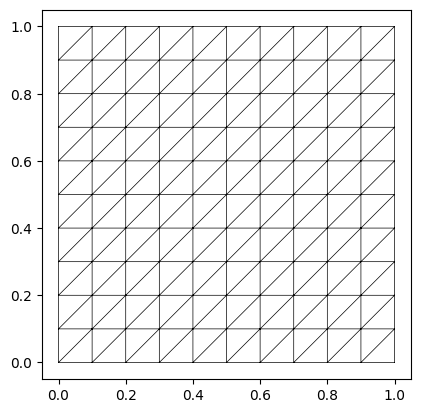

In [4]:
plt.triplot(*mesh.coords.T, mesh.elements, color="k", lw=0.5)
plt.gca().set_aspect("equal")

## Constitutive Model for Linear Elasticity

We define a function to compute the linear elastic energy density based on the displacement gradients $\nabla u$.

$$
\Psi(x) =  \sigma(x) : \epsilon(x)
$$

where $\sigma$ is the stress tensor and $\epsilon$ is the strain tensor.

$$
\sigma = \lambda \text{tr}(\epsilon) I + 2\mu \epsilon
$$

and

$$
\epsilon = \frac{1}{2} (\nabla u + \nabla u^T)
$$

The elastic strain energy density is then given by:

$$
\Psi_{elastic}(u) = \int_{\Omega} \Psi(x) dV
$$


The femsolver provides a generic class `Operator` that can be used to solve FEM problems. This operator is the core of the library as it provide functions that can automatically integrate the energy density function defined above over the range of elements.


In [5]:
def compute_strain(grad_u: Array) -> Array:
    """Compute the strain tensor from the gradient of the displacement."""
    return 0.5 * (grad_u + grad_u.swapaxes(-1, -2))


def compute_stress(eps: Array, mu: float, lmbda: float) -> Array:
    """Compute the stress tensor from the strain tensor."""
    I = jnp.eye(2)
    return 2 * mu * eps + lmbda * jnp.trace(eps) * I


def strain_energy(grad_u: Array, mu: float, lmbda: float) -> Array:
    """Compute the strain energy density."""
    eps = compute_strain(grad_u)
    sig = compute_stress(eps, mu, lmbda)
    return 0.5 * jnp.sum(eps * sig)


@op.integrate
def total_strain_energy(u: Array, u_grad: Array, *_) -> Array:
    """Compute the total energy of the system."""
    return strain_energy(u_grad, mat.mu, mat.lmbda)

The total potential energy $\Psi$ is the sum of the elastic strain energy $\Psi_{elastic}$ and the contact penalty energy $\Psi_{contact}$.

$$\Psi(u)=\Psi_{elastic}(u)+\Psi_{contact}(u)$$

The contact energy is defined as:

$$\Psi_{contact}(u)=\frac{1}{2}k_{pen}\int_{\Gamma_c}\langle -g(u)\rangle^2 dA$$

For this example, we define the discrete penalization only at the nodes on the contact surface.
Therefore, the contact energy is defined as:

$$\Psi_{contact}(u)=\frac{1}{2}k_{pen}\sum_{i=1}^{N_c}\langle -g(u_i)\rangle^2 A_{i}$$

where $N_c$ is the number of nodes on the contact surface, $A_i$ is the area of the node $i$, and $g(u_i)$ is the gap function at node $i$.

The gap function is defined as:

$$g(u_i)=x_i+u_i-0.0$$


In [6]:
def compute_contact_energy(u: Array, coords: Array, contact_nodes: Array) -> Array:
    """Compute the contact energy for a given displacement field.
    Args:
        u: Displacement field.
        coords: Coordinates of the nodes.
        contact_nodes: Indices of the nodes on the contact surface.
    Returns:
        Contact energy.
    """
    u_nodes = u[contact_nodes]
    x_nodes = coords[contact_nodes]

    k_pen = 1e2
    node_area_weight = 1.0  # TODO: add the correctarea of the node

    # Loop over nodes on the potential contact surface
    @vmap(in_axes=(0, 0))
    def contact_energy_node(u_node, x_node):
        gap = (x_node[0] + u_node[0]) - 0.0
        penetration = jnp.maximum(-gap, 0.0)
        return 0.5 * k_pen * (penetration**2) * node_area_weight

    return jnp.sum(contact_energy_node(u_nodes, x_nodes))


@jax.jit
def total_energy(
    u_flat: Array,
    coords: Array,
    contact_nodes: Array,
) -> Array:
    """Compute the total energy for a given displacement field.
    Args:
        u_flat: Flattened displacement field.
        coords: Coordinates of the nodes.
        contact_nodes: Indices of the nodes on the contact surface.
    Returns:
        Total energy.
    """
    u = u_flat.reshape(-1, n_dofs_per_node)
    contact_energy = compute_contact_energy(u, coords, contact_nodes)
    strain_energy = total_strain_energy(u)
    return contact_energy + strain_energy


## Solve system

We arrange the system such that the unknown vector $u$ is flattened. Once we find the solution, we will reshape it back to the original shape.

1. create the unknown vector $u$ with the shape of the number of nodes times the number of degrees of freedom per node
2. create the system matrix $K$ and the right-hand side vector $f$
3. solve the system $K u = f$ for $u$

::: {.callout-note}
We apply the boundary condition using matrix lifting
:::


In [ ]:
u = jnp.zeros((n_dofs))

residual = jax.grad(total_energy)
hessian = jax.jacfwd(residual)

contact_nodes = jnp.where(jnp.isclose(mesh.coords[:, 0], 0.0))[0]
right_nodes = jnp.where(jnp.isclose(mesh.coords[:, 0], 1.0))[0]

fixed_dofs = jnp.concatenate([2 * right_nodes])
prescribed_values = jnp.zeros_like(u).at[2 * right_nodes].set(-0.5)
free_dofs = jnp.setdiff1d(jnp.arange(n_dofs), fixed_dofs)

K = hessian(u, mesh.coords, contact_nodes)
f_int = residual(u, mesh.coords, contact_nodes)

f_ext = -f_int - K @ prescribed_values
f_reduced = f_ext[free_dofs]
K_reduced = K[jnp.ix_(free_dofs, free_dofs)]
u_free = jnp.linalg.solve(K_reduced, f_reduced)
u_full = prescribed_values.at[free_dofs].set(u_free)

## Postprocessing

Let's plot the von Mises stress and the deformed configuration.


In [20]:
@auto_vmap(stress=2)
def von_mises_stress(stress):
    s_xx, s_yy = stress[0, 0], stress[1, 1]
    s_xy = stress[0, 1]
    return jnp.sqrt(s_xx**2 - s_xx * s_yy + s_yy**2 + 3 * s_xy**2)


u_solution = u_full.reshape(-1, n_dofs_per_node)
# squeeze to remove the quad point dimension (only 1 quad point)
grad_u = op.grad(u_solution).squeeze()
strains = compute_strain(grad_u)
stresses = compute_stress(strains, mat.mu, mat.lmbda)
stress_vm = von_mises_stress(stresses)

In [21]:
from matplotlib.pyplot import xlabel
from femsolver.plotting import STYLE_PATH
from matplotlib.axes import Axes

plt.style.use(STYLE_PATH)


def plot_displacement_and_stress(
    ax: Axes, u: Array, mesh: Mesh, stress: Array, scale=1.0
) -> None:
    coords, elements = mesh.coords, mesh.elements
    displaced = coords + scale * u

    ax.triplot(
        coords[:, 0],
        coords[:, 1],
        elements,
        color="black",
        linewidth=0.5,
    )
    cb = ax.tripcolor(
        displaced[:, 0],
        displaced[:, 1],
        elements,
        facecolors=stress,
        shading="flat",
        cmap=cmc.managua_r,
        edgecolors="black",
    )
    plt.colorbar(cb, label="Von Mises Stress")
    ax.set(xlabel="x", ylabel="y", title="Von Mises Stress on Deformed Mesh")
    ax.axis("equal")


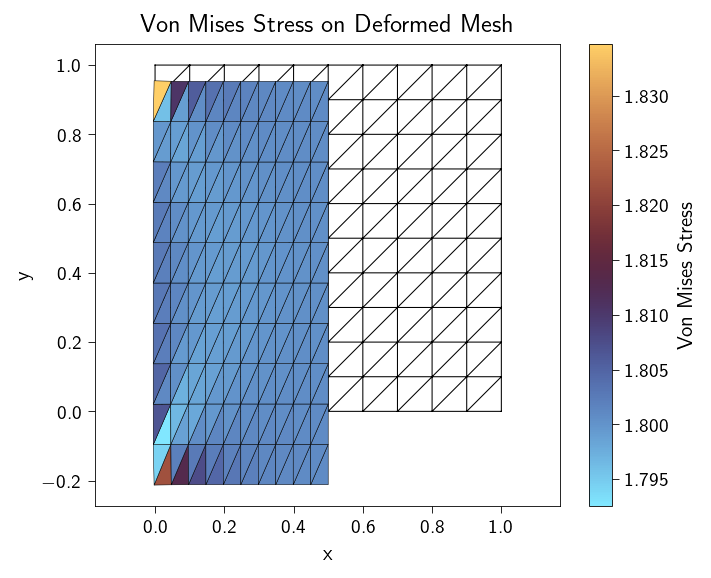

In [ ]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111)

plot_displacement_and_stress(ax, u_solution, mesh, stress_vm)